In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(patchwork)
    library(nloptr)
    library(adoptr)
})

set.seed(42)
source("../R/util.R")
dir.create("../output/figures", recursive = TRUE, showWarnings = FALSE)

# restore optimal two-stage design
optimal_design <- read_rds("optimal_design.RDS") # needs to run 02-naive-recalculation-and-optimal-design first

options(repr.plot.width = 12, repr.plot.height = 5)

Loading required package: renv


Attaching package: ‘renv’


The following object is masked from ‘package:stats’:

    update


The following objects are masked from ‘package:utils’:

    history, upgrade


The following objects are masked from ‘package:base’:

    load, remove




* The library is already synchronized with the lockfile.


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'optimal_design.RDS', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, "rb"): cannot open the connection


## Conditional power contraints for unplanned adaptations

The previous considerations are all about pre-planning optimal adaptation rules. 
This is fundamentally different from unplanned design adaptation. 
For unplanned adaptation, a (not necessarily optimal) design is given and stopped at some $m<n$. 
Here we restrict the considerations to a single stage design $(n, c)$. 
All considerations can be extended to multistage designs though.

The minimal predictive power constraint can also be critizised from the perspective of unplanned adaptations.
Going back to the 'ad-hoc adaptation' discussed earlier, 
it is clear that there is an assymetry with respect to how type-one and type-two error rates conditional on $Z_m=z_m$ are handled.
For the conditional type one error rate, the conditional error principle is invoked to ensure that the overall error level is not inflated. 
For the predictive power (expected conditional type two error rate) however an arbitrary fixed threshold is used. 

Instead, one could also apply the conditional error principle to both the maximal type one error rate and type two error rate, i.e., require

\begin{align}
    \PP_{n'}(z_m, c') &\geq \PP_{n}(z_m, \crit) \\
    \CP_{n'}(z_m, c', 0) &\leq \CP_{n}(z_m, \crit, 0),\ n'_{min} \leq n' \leq n_{max}, m < n'_{min} \ .
\end{align}

Trivially, the original design would then be invariant under recalculation since the original $(n, \crit)$ satisfies all constraints with equality and the two constraints already determine $(n', c')$ uniquely.

If the orignal design $(n,c)$ was obtained as solution to an optimaization problem, e.g.,

\begin{align}
    &\operatorname{argmin}(n, c) \quad & n                                   &  \\
    &\text{subject to} \quad          & \Pr_{0}[\,Z_{n} > c\,]              & \leq \alpha \\
    &                                  & \Pr[\,Z_{n} > c \cond\Theta > 0 \,] & \geq 1 - \beta \ 
\end{align}

and there is no new trial-external information, why should the optimal design be changed? 
In fact, one could make the case that this 'invariance priniple' should always hold if the original design was planned thoroughly.

[I removed the adapt2 approach; it was only to confirm that I did not overlook anything; the recalculated design is indeed invariant]

So, when does an unplanned sample size adaptation make sense then? 
There are mainly two reasons, 

1. the original design wa planned badly, e.g., there is a desire to change the power levels or similar
2. there is new trial-external evidence that lead to a change in the prior from $\varphi$ to $\psi$.

In both situations, one would still like to maintain strict type one error rate control for the final hypothesis test after adaptation (conditional error principle).

Focusssing on (2.), a natural criterion to determine the required sample size of the remaining trial could be to
maintain the same chances of detecting an effect under the new prior given the data as had been planned for under the old prior.
This leads to the conditional problem 

\begin{align}
    &\operatorname{argmin}(n', c') \quad & n' &\\
    &\text{subject to} \quad & \Pr_{0}[\,Z_{n'} > c'\cond Z_m=z_m\,] &\leq \Pr_{0}[\,Z_{n} > c\cond Z_m=z_m\,] \\
        & & \Pr_\psi[\,Z_{n'} > c' \cond \Theta > 0,Z_m=z_m \,] &\geq \Pr_\varphi[\,Z_{n} > c \cond \Theta > 0,Z_m=z_m \,]  \ .
\end{align}

The interesting modification is the constraint $\Pr_\psi[\,Z_{n'} > c' \cond \Theta > 0, Z_m=z_m \,] \geq \Pr_\varphi[\,Z_{n} > c \cond \Theta > 0, Z_m=z_m \,]$.
Since the prior on the left hand side is different, the original $(n, c)$ will no longer fulfill the constraints leading to a new solution. 

[this is what I conjured up, not sure I already hit home here. The crucial question is: how do you map the original unconditional power constraint to the conditional situation? I oppose $PP > 1-beta_c$ because 1) it treats type one and type two error rates fundamentally different and 2) the original design would not be invariant under no prior change! Esp. the latter one should be a core criterion for any adaptive design modification!]

In [2]:
prior <- TruncatedNormal(mu = 0.4, tau = 0.2, a = -0.5, b = 1.0)

n_max <- 160
    m <- 35

critical_value <- function(design, zm) {
     n =  adoptr::n(design, zm)
    n1 = adoptr::n1(design)
    c2 = adoptr::c2(design, zm)
    if (!is.finite(c2)) return(c2)
    sqrt(n - n1) / sqrt(n) * c2 + sqrt(n1/n) * zm
}

In [3]:
# adapt at original interim analysis
adapt <- function(priormean, zm) {
    n_old <- adoptr::n(optimal_design, zm, round = FALSE)
    c_old <- critical_value(optimal_design, zm)
    if (!is.finite(c_old)) 
        return(list(
            n = n_old,
            c = c_old,
            optim = NULL
        ))
    # old conditional type-I error
    alpha_bar <- conditional_power(zm, m, n_old, c_old, 0)
    # old conditional type-II error
    beta_bar <- 1 - predictive_power(zm, m, n_old, c_old, prior)
    new_prior <- TruncatedNormal(priormean, 0.2, -0.5, 1.0)
    target <- function(x) {
        n_bar <- x[1]; c_bar <- x[2]
        alpha <- conditional_power(zm, m, n_bar, c_bar, 0)
         beta <- predictive_power(zm, m, n_bar, c_bar, new_prior)
        res <- (alpha - alpha_bar)^2 + 
            (beta - (1 - beta_bar))^2
        res
    }
    res <- optim(
        par = c(n_old, c_old), 
        fn = target, 
        lower = c(m + 1, 0), 
        upper = c(n_max, 5), 
        method = "L-BFGS-B",
        control = list(fnscale = 1e-5, parscale = c(1/10, 1))
    )
    list(
        n = if (abs(res$par[1] - n_max) < 0.1) m else res$par[1],
        c = if (abs(res$par[1] - n_max) < 0.1) Inf else res$par[2],
        optim = res
    )
}

In [4]:
thetas <- seq(0.3, 0.4, by = 0.05)

tbl_adapted <- expand_grid(
            zm = sqrt(m)*thetas,
    `new mean` = seq(-0.5, 1, length.out = 100)
) %>%
mutate(
    tmp = map2(`new mean`, zm, ~{tmp <- adapt(..1, ..2); tibble(n = tmp$n, c = tmp$c)})
) %>%
unnest(tmp) %>%
mutate(
    section = if_else(c == Inf, "early futility", "continue"),
     effect = factor(zm/sqrt(m))
)

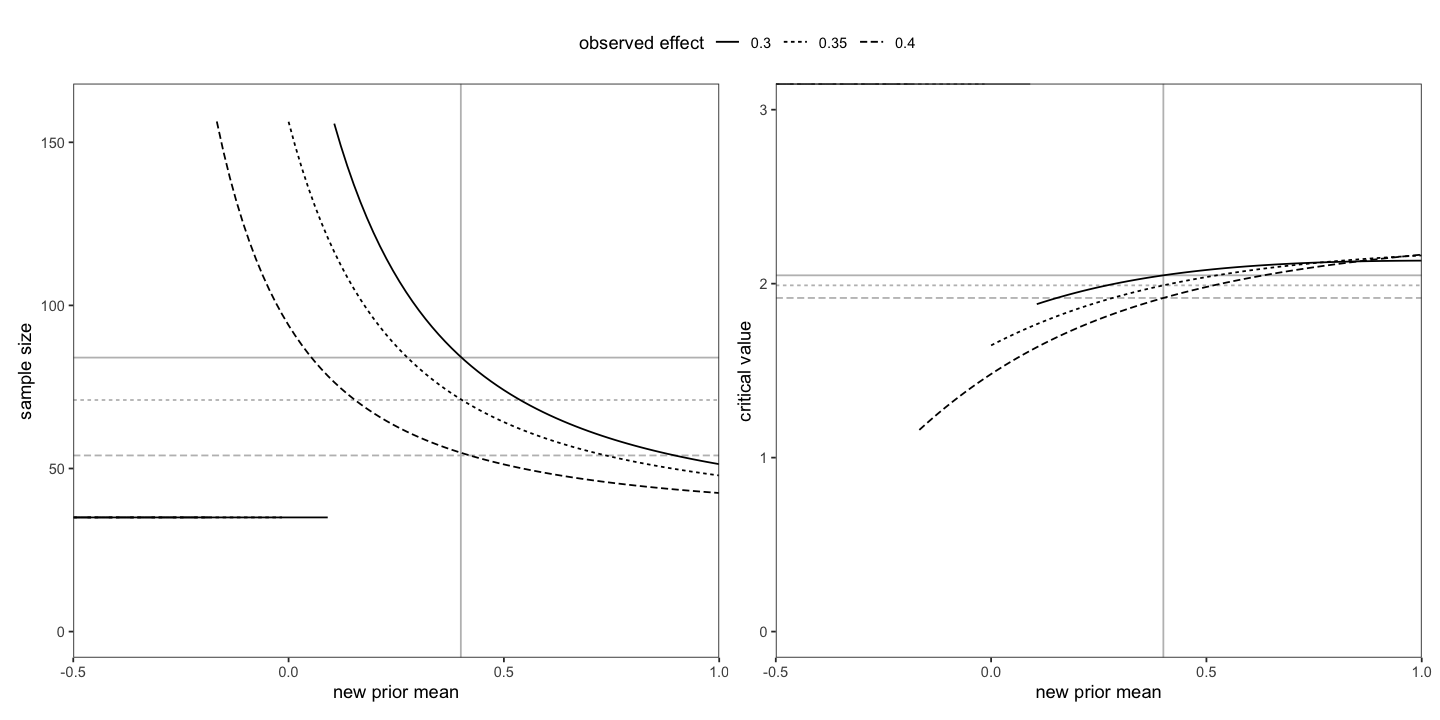

In [5]:
options(repr.plot.width = 12, repr.plot.height = 6)

tbl_original <- tibble(
    effect = thetas,
         n = map_dbl(effect, ~n(optimal_design, sqrt(m)*.)),
         c = map_dbl(effect, ~critical_value(optimal_design, sqrt(m)*.))
) %>% 
mutate(
    effect = factor(effect)
)

plt1 <- ggplot(tbl_adapted) +
    aes(`new mean`, n, group = interaction(section, effect)) +
    geom_hline(aes(yintercept = n, linetype = effect), color = "grey", data = tbl_original) + 
    geom_vline(xintercept = 0.4, color = "grey") + 
    geom_line(aes(linetype = effect)) +
    scale_x_continuous('new prior mean', expand = c(0, 0)) +
    scale_y_continuous('sample size', limits = c(0, n_max)) +
    scale_linetype('observed effect') +
    theme_bw() + 
    theme(
        legend.position = 'top',
        panel.grid = element_blank()
    )

plt2 <- ggplot(tbl_adapted) +
    aes(`new mean`, c, group = interaction(section, effect)) +
    geom_hline(aes(yintercept = c, linetype = effect), color = "grey", data = tbl_original) + 
    geom_vline(xintercept = 0.4, color = "grey") + 
    geom_line(aes(linetype = effect)) +
    scale_x_continuous('new prior mean', expand = c(0, 0)) +
    scale_y_continuous('critical value', limits = c(0, 3)) +
    scale_linetype('observed effect') +
    theme_bw() + 
    theme(
        legend.position = 'top',
        panel.grid = element_blank()
    )

plt1 + plt2 + plot_layout(guides = "collect") & theme(legend.position = 'top')

In [6]:
ggsave("../output/figures/recalculation-type-II-original-m.pdf", width = 8, height = 4.5)

In [7]:
conditional_power_before_interim <- function(design, mbar, zmbar, theta) {
    m <- adoptr::n1(design)
    if ((0 >= mbar) | (mbar >= m)) stop()
    tau <- mbar/m
    # distribution of zm | zmbar is conditional normal with 
    mu <- sqrt(m)*theta + sqrt(tau) * (zmbar - sqrt(mbar)*theta)
    sd <- sqrt(1 - tau)
    # everything to the left of the futilty bound is no rejection / does not contribute, start with [c1f, c1e]
      mid <- integrate_gl(
          function(zm) {
              map_dbl(
                  zm, 
                  ~conditional_power(., m, n(design, ., round = FALSE), critical_value(design, .), theta) *  dnorm(., mu, sd)
              )
          }, 
          design@c1f, design@c1e
    )
    # last bit: [c1e, Inf)
    right <- pnorm(design@c1e, mu, sd, lower.tail = FALSE)
    # combine
    mid + right
}

In [8]:
predictive_power_before_interim <- function(design, mbar, zmbar, prior) {
    m <- adoptr::n1(design)
    if ((0 >= mbar) | (mbar >= m)) stop()
    tau <- mbar/m
    # distribution of zm | zmbar is conditional normal with 
    mu <- function(theta) sqrt(m)*theta + sqrt(tau) * (zmbar - sqrt(mbar)*theta)
    sd <- sqrt(1 - tau)
    # everything to the left of the futilty bound is no rejection / does not contribute, start with [c1f, c1e]
      mid <- integrate_gl(
          function(theta) {
              map_dbl(theta, function(theta) {integrate_gl(
                  function(zm) {
                      map_dbl(zm, ~conditional_power(., m, adoptr::n(design, ., round = FALSE), critical_value(design, .), theta) * 
                              dnorm(., mu(theta), sd) *
                              probability_density(posterior(condition(prior, 0), mbar, zmbar), theta)
                      )
                  }, 
                  design@c1f, design@c1e
              )}
            )
        },
        prior$a, prior$b
    )
    # last bit: [c1e, Inf)
    right <- integrate_gl(
        function(theta) {
            pnorm(design@c1e, mu(theta), sd, lower.tail = FALSE) * 
                probability_density(posterior(condition(prior, 0), mbar, zmbar), theta)
        }, 
        prior$a, prior$b
    )
    # combine
    mid + right
}

In [9]:
# adapt before original interim analysis
n_max = 160

adapt <- function(priormean, mbar, zmbar) {
    # old conditional type-I error
    alpha_bar <- conditional_power_before_interim(optimal_design, mbar, zmbar, 0)
    # old conditional type-II error
    beta_bar <- 1 - predictive_power_before_interim(optimal_design, mbar, zmbar, prior)
    new_prior <- TruncatedNormal(priormean, 0.2, -0.5, 1.0)
    target <- function(x) {
        n_bar <- x[1]
        c_bar <- x[2]
        alpha <- conditional_power(zmbar, mbar, n_bar, c_bar, 0)
         beta <-  predictive_power(zmbar, mbar, n_bar, c_bar, new_prior)
        (alpha - alpha_bar)^2 + (beta - (1 - beta_bar))^2
    }
    res <- optim(
        par = c(50, 2), 
        fn = target, 
        lower = c(mbar + 1, 0), 
        upper = c(n_max, 5), 
        method = "L-BFGS-B",
        control = list(fnscale = 1e-5, parscale = c(1, 1/100))
    )
    n_bar <- if (round(res$par[1]) >= n_max) mbar else res$par[1]
    c_bar <- if (round(res$par[1]) >= n_max)  Inf else res$par[2]
    alpha_violation <- max(0, conditional_power(zmbar, mbar, n_bar, c_bar, 0) - alpha_bar)
    power_violation <- max(0, 1 - beta_bar - predictive_power(zmbar, mbar, n_bar, c_bar, new_prior))
    if (any(c(alpha_violation, power_violation) > 1e-4)) {
        n_bar <- mbar
        c_bar <- Inf
        alpha_violation <- max(0, conditional_power(zmbar, mbar, n_bar, c_bar, 0) - alpha_bar)
        power_violation <- max(0, 1 - beta_bar - predictive_power(zmbar, mbar, n_bar, c_bar, new_prior))
    }
    list(
        n = n_bar,
        c = c_bar,
        alpha_violation = alpha_violation,
        power_violation = power_violation,
        optim = res
    )
}

In [10]:
library(future)
plan(multisession)

In [11]:
tbl_adapted <- expand_grid(
          mbar = c(seq(15, 30, by = 5), 34),
    `new mean` = seq(-0.5, 1, length.out = 50)
) %>%
mutate(
    zmbar = sqrt(mbar)*0.3,
      tmp = pmap(list(`new mean`, mbar, zmbar), function(mu, mbar, zmbar) future({source("util.R"); adapt(mu, mbar, zmbar)}))
) %>% 
mutate(
    tmp = map(
        tmp, 
        ~tibble(n = value(.)$n, c = value(.)$c)
    )
) %>%
unnest(tmp) %>%
mutate(
    section = if_else(c == Inf, "early futility", "continue"),
     effect = factor(zmbar/sqrt(mbar)),
       mbar = factor(mbar)
)

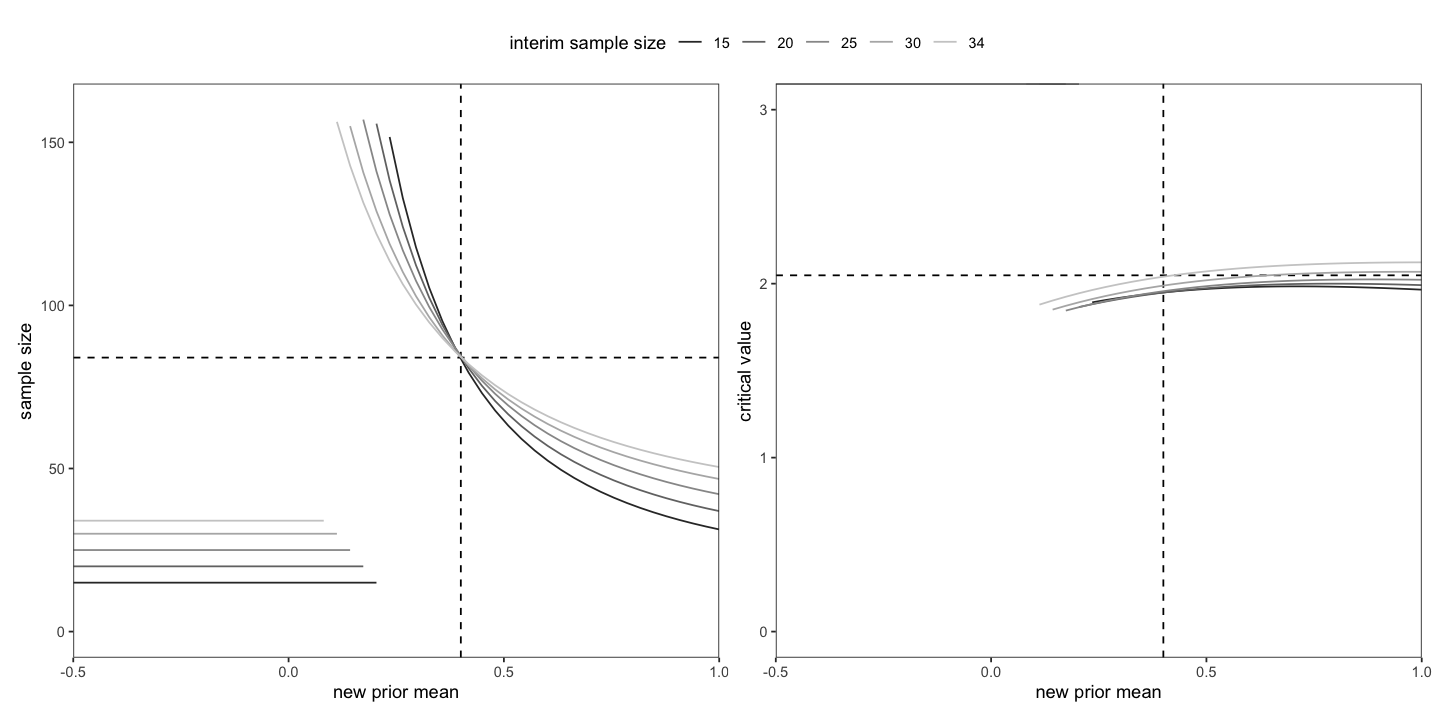

In [12]:
options(repr.plot.width = 12, repr.plot.height = 6)

tbl_original <- tibble(
    effect = 0.3,
      mbar = 35,
         n = map_dbl(effect, ~n(optimal_design, sqrt(mbar)*.)),
         c = map_dbl(effect, ~critical_value(optimal_design, sqrt(mbar)*.))
    ) %>% 
    mutate(
        effect = factor(effect),
        mbar = factor(mbar)
    )

plt1 <- ggplot(tbl_adapted) +
    aes(`new mean`, n, group = interaction(section, mbar)) +
    geom_hline(aes(yintercept = n), linetype = 2, data = tbl_original) + 
    geom_vline(xintercept = 0.4, linetype = 2) + 
    geom_line(aes(color = mbar)) +
    scale_x_continuous('new prior mean', expand = c(0, 0)) +
    scale_y_continuous('sample size', limits = c(0, n_max)) +
    scale_color_grey('interim sample size') +
    theme_bw() + 
    theme(
        legend.position = 'top',
        panel.grid = element_blank()
    )

plt2 <- ggplot(tbl_adapted) +
    aes(`new mean`, c, group = interaction(section, mbar)) +
    geom_hline(aes(yintercept = c), linetype = 2, data = tbl_original) + 
    geom_vline(xintercept = 0.4, linetype = 2) + 
    geom_line(aes(color = mbar)) +
    scale_x_continuous('new prior mean', expand = c(0, 0)) +
    scale_y_continuous('critical value', limits = c(0, 3)) +
    scale_color_grey('interim sample size') +
    theme_bw() + 
    theme(
        legend.position = 'top',
        panel.grid = element_blank()
    )

plt1 + plt2 + plot_layout(guides = "collect") & theme(legend.position = 'top')

In [13]:
ggsave("../output/figures/recalculation-type-II-earlier.pdf", width = 8, height = 4.5)